<div align = "center">
    <u><h1>Pulmonary Embolism</h1></u>
    <img src = "https://external-content.duckduckgo.com/iu/?u=https%3A%2F%2Fwww.ihtc.org%2FUserFiles%2FImage%2Fimg_throm_pulmonaryembolism.jpg&f=1&nofb=1">
    
</div>

## About Pulmonary Embolism:

Pulmonary embolism (PE) is a sudden blockage in a lung artery. It usually happens when a blood clot breaks loose and travels through the bloodstream to the lungs. 

PE is a serious condition that can cause:

- Permanent damage to the lungs
- Low oxygen levels in your blood
- Damage to other organs in your body from not getting enough oxygen

PE can be life-threatening, especially if a clot is large, or if there are many clots.

## How can we help?

We can use ML/DL techniques which could help to more accurately identify PE cases, making management and treatment more effective for patients.

The competition data consists of CT scans, which consist of hundreds of images that require detailed review to identify clots within the pulmonary arteries.

# Table of Contents:

- ## 1.1 [Lung Segmentation](https://www.kaggle.com/aadhavvignesh/making-use-of-ct-scans-pulmonary-embolism#1.1-Lung-Segmentation)
- ## 1.2 [Calculating Lung Volume](https://www.kaggle.com/aadhavvignesh/making-use-of-ct-scans-pulmonary-embolism#1.2-Calculating-Lung-Volumes-from-CT-Scans)
- ## 1.3 [Inspecting Tabular Data](https://www.kaggle.com/aadhavvignesh/making-use-of-ct-scans-pulmonary-embolism#1.3-Checking-the-tabular-data)

### This work is based on my [previous work](https://www.kaggle.com/aadhavvignesh/lung-segmentation-by-marker-controlled-watershed).

# 1.1 Lung Segmentation
The basic idea behind watershed segmentation is that any grayscale can be considered as a topographic surface.
If we flood the surface from its minima, and successfully prevent merging of waters, we partition the image into two different sets: the catchment basins and the watershed lines.

![Watershed](http://www.cmm.mines-paristech.fr/~beucher/lpe1.gif)![Final Watersheds](http://www.cmm.mines-paristech.fr/~beucher/ima3.gif)

> Image Source: [CMM](http://www.cmm.mines-paristech.fr/~beucher/wtshed.html)

We'll be using `pydicom` for dealing with the scans, feel free to use any available library:

In [1]:
!pip install pydicom

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import pydicom
import os
import scipy.ndimage as ndimage
from skimage import measure, morphology, segmentation
import matplotlib.pyplot as plt

import time

Let's load the patients' data:

In [3]:
INPUT_FOLDER = '/kaggle/input/rsna-str-pulmonary-embolism-detection/train/'

patients_studyuid = os.listdir(INPUT_FOLDER)
patients_studyuid.sort()

print("Some examples of patient Study UIDs:")
print(",\n".join(patients_studyuid[:5]))


series_uids = []
for study_uid in patients_studyuid[:5]:
    series_uid = os.listdir(INPUT_FOLDER + study_uid)[0]
#     print("Series UID:", series_uid)
    series_uids.append(INPUT_FOLDER + study_uid + '/' + series_uid)

Some examples of patient Study UIDs:
0003b3d648eb,
000f7f114264,
00102474a2db,
0038fd5f09f5,
0045f113e031


Now let's load the scans:

This code for loading the scans is based on Franklin Heng's [Medium article.](https://medium.com/@hengloose/a-comprehensive-starter-guide-to-visualizing-and-analyzing-dicom-images-in-python-7a8430fcb7ed)

In [4]:
def load_scan(path):
    """
    Loads scans from a folder and into a list.
    
    Parameters: path (Folder path)
    
    Returns: slices (List of slices)
    """
    
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

## Hounsfield Units

The unit of measurement in CT scans is the Hounsfield Unit (HU), which is a measure of radiodensity. 

**Hounsfield units (HU)** are a dimensionless unit universally used in computed tomography (CT) scanning to express CT numbers in a standardized and convenient form. Hounsfield units are obtained from a linear transformation of the measured attenuation coefficients.

HUs can be calculated from the pixel data with a DICOM Image using the following formula:

$\large HU = m*P + b$

where,

$m$ = `RescaleSlope` attribute of the DICOM image,

$b$ = `RescaleIntercept` attribute of the DICOM image,

$P$ = Pixel Array

In [5]:
def get_pixels_hu(scans):
    """
    Converts raw images to Hounsfield Units (HU).
    
    Parameters: scans (Raw images)
    
    Returns: image (NumPy array)
    """
    
    image = np.stack([s.pixel_array for s in scans])
    image = image.astype(np.int16)

    # Since the scanning equipment is cylindrical in nature and image output is square,
    # we set the out-of-scan pixels to 0
    image[image == -2000] = 0
    
    
    # HU = m*P + b
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Let's store store the slices and the images:

In [6]:
test_patient_scans = load_scan(series_uids[0])
test_patient_images = get_pixels_hu(test_patient_scans)

We'll be taking a random slice to perform segmentation:

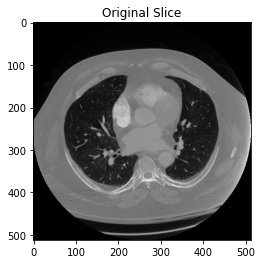

In [7]:
plt.imshow(test_patient_images[100], cmap='gray')
plt.title("Original Slice")
plt.show()

# Marker-Controlled Watershed Transformation

**Watershed Transform** is a really powerful segmentation algorithm, but has a drawback where every regional minimum forms its own catchment basin. To overcome this drawback, we use a marker-controlled watershed transformation, where we manually create markers where we start the flooding process.

## About the Algorithm:

The image is seen as a topographical surface where grey values are deemed as elevation of the surface at that location. Then, flooding process starts in which water effuses out of the minimum grey value or the marker. When flooding across two minimum converges then a dam is built to identify the boundary across them.


![Markers](http://www.cmm.mines-paristech.fr/~beucher/ima4.gif)
![Flood](http://www.cmm.mines-paristech.fr/~beucher/lpe2.gif)

## Marker Generation:

For using marker-controlled watershed segmentation, we'll need to identify markers. Internal marker, which is our region of interest, i.e lung tissue and an external marker, which is the region outside of our region of interest.

We create the external marker is created by morphological dilation of the internal marker, by iterating twice and subtracting the results. The watershed marker is created by superimposing both the markers.

Some of the code is based from @arnavkj95's kernel: https://www.kaggle.com/arnavkj95/candidate-generation-and-luna16-preprocessing

In [8]:
def generate_markers(image):
    """
    Generates markers for a given image.
    
    Parameters: image
    
    Returns: Internal Marker, External Marker, Watershed Marker
    """
    
    #Creation of the internal Marker
    marker_internal = image < -400
    marker_internal = segmentation.clear_border(marker_internal)
    marker_internal_labels = measure.label(marker_internal)
    
    areas = [r.area for r in measure.regionprops(marker_internal_labels)]
    areas.sort()
    
    if len(areas) > 2:
        for region in measure.regionprops(marker_internal_labels):
            if region.area < areas[-2]:
                for coordinates in region.coords:                
                       marker_internal_labels[coordinates[0], coordinates[1]] = 0
    
    marker_internal = marker_internal_labels > 0
    
    # Creation of the External Marker
    external_a = ndimage.binary_dilation(marker_internal, iterations=10)
    external_b = ndimage.binary_dilation(marker_internal, iterations=55)
    marker_external = external_b ^ external_a
    
    # Creation of the Watershed Marker
    marker_watershed = np.zeros((512, 512), dtype=np.int)
    marker_watershed += marker_internal * 255
    marker_watershed += marker_external * 128
    
    return marker_internal, marker_external, marker_watershed

Let's get our markers for the sample slice:

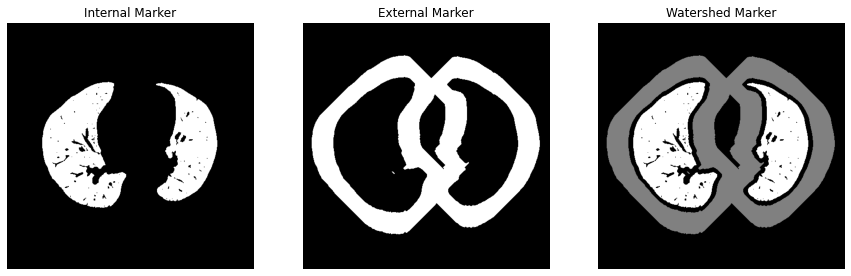

In [9]:
test_patient_internal, test_patient_external, test_patient_watershed = generate_markers(test_patient_images[100])

f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,15))

ax1.imshow(test_patient_internal, cmap='gray')
ax1.set_title("Internal Marker")
ax1.axis('off')

ax2.imshow(test_patient_external, cmap='gray')
ax2.set_title("External Marker")
ax2.axis('off')

ax3.imshow(test_patient_watershed, cmap='gray')
ax3.set_title("Watershed Marker")
ax3.axis('off')

plt.show()

## Sobel Gradient and Edge Outlining

The Sobel operator performs a 2D spatial gradient measurement on an image and so emphasizes regions of high spatial frequency that correspond to edges.

It consists of a pair of 3×3 convolution kernels.

![Conv Filters](http://homepages.inf.ed.ac.uk/rbf/HIPR2/figs/sobmasks.gif)

These kernels can then be combined together to find the absolute magnitude of the gradient at each point and the orientation of that gradient.

The gradient magnitude is given by:
$G = sqrt(Gx^2 + Gy^2)$

Sobel gradient can be calculated by `scipy.ndimage`.

In [10]:
# Lists to store computation times and iterations
computation_times = []
iteration_titles = []

In [11]:
def seperate_lungs(image, iterations = 1):
    """
    Segments lungs using various techniques.
    
    Parameters: image (Scan image), iterations (more iterations, more accurate mask)
    
    Returns: 
        - Segmented Lung
        - Lung Filter
        - Outline Lung
        - Watershed Lung
        - Sobel Gradient
    """
    
    # Store the start time
    start = time.time()
    
    marker_internal, marker_external, marker_watershed = generate_markers(image)
    
    
    '''
    Creation of Sobel Gradient
    '''
    
    # Sobel-Gradient
    sobel_filtered_dx = ndimage.sobel(image, 1)
    sobel_filtered_dy = ndimage.sobel(image, 0)
    sobel_gradient = np.hypot(sobel_filtered_dx, sobel_filtered_dy)
    sobel_gradient *= 255.0 / np.max(sobel_gradient)
    
    
    '''
    Using the watershed algorithm
    
    
    We pass the image convoluted by sobel operator and the watershed marker
    to morphology.watershed and get a matrix matrix labeled using the 
    watershed segmentation algorithm.
    '''
    watershed = morphology.watershed(sobel_gradient, marker_watershed)
    
    '''
    Reducing the image to outlines after Watershed algorithm
    '''
    outline = ndimage.morphological_gradient(watershed, size=(3,3))
    outline = outline.astype(bool)
    
    
    '''
    Black Top-hat Morphology:
    
    The black top hat of an image is defined as its morphological closing
    minus the original image. This operation returns the dark spots of the
    image that are smaller than the structuring element. Note that dark 
    spots in the original image are bright spots after the black top hat.
    '''
    
    # Structuring element used for the filter
    blackhat_struct = [[0, 0, 1, 1, 1, 0, 0],
                       [0, 1, 1, 1, 1, 1, 0],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [1, 1, 1, 1, 1, 1, 1],
                       [0, 1, 1, 1, 1, 1, 0],
                       [0, 0, 1, 1, 1, 0, 0]]
    
    blackhat_struct = ndimage.iterate_structure(blackhat_struct, iterations)
    
    # Perform Black Top-hat filter
    outline += ndimage.black_tophat(outline, structure=blackhat_struct)
    
    '''
    Generate lung filter using internal marker and outline.
    '''
    lungfilter = np.bitwise_or(marker_internal, outline)
    lungfilter = ndimage.morphology.binary_closing(lungfilter, structure=np.ones((5,5)), iterations=3)
    
    '''
    Segment lung using lungfilter and the image.
    '''
    segmented = np.where(lungfilter == 1, image, -2000*np.ones((512, 512)))
    
    # Append computation time
    end = time.time()
    computation_times.append(end - start)
    iteration_titles.append("{num} iterations".format(num = iterations))
    
    
    return segmented, lungfilter, outline, watershed, sobel_gradient

## Comparison of iterations with time

We'll be checking for iterations in the range of 1-8. `iterations = 1` is the default for the `seperate_lungs` function.

In [12]:
for itrs in range(1, 9):
    test_segmented, test_lungfilter, test_outline, test_watershed, test_sobel_gradient = seperate_lungs(test_patient_images[100], itrs)

In [13]:
itr_dict = {'Iterations' : iteration_titles, 'Computation Times (in seconds)': computation_times}

colors = ['#30336b',] * 8
colors[0] = '#eb4d4b'

import plotly.express as px
import plotly.graph_objects as go


fig = go.Figure(data=[go.Bar(
    x=itr_dict['Iterations'],
    y=itr_dict['Computation Times (in seconds)'],
    marker_color = colors
)])
fig.update_traces(texttemplate='%{y:.3s}', textposition='outside')


fig.update_layout(
    title = 'Iterations vs Computation Times',
    yaxis=dict(
        title='Computation Times (in seconds)',
        titlefont_size=16,
        tickfont_size=14,
    ),
    autosize=False,
    width=800,
    height=800)

fig.show()


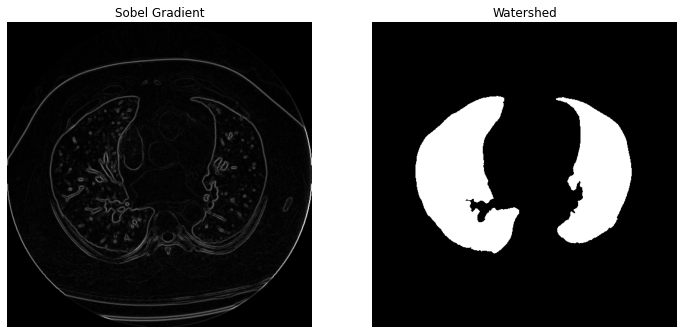

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12, 12))

ax1.imshow(test_sobel_gradient, cmap='gray')
ax1.set_title("Sobel Gradient")
ax1.axis('off')

ax2.imshow(test_watershed, cmap='gray')
ax2.set_title("Watershed")
ax2.axis('off')

plt.show()

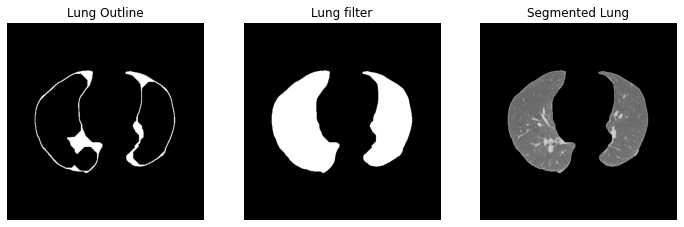

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize = (12, 12))

ax1.imshow(test_outline, cmap='gray')
ax1.set_title("Lung Outline")
ax1.axis('off')

ax2.imshow(test_lungfilter, cmap='gray')
ax2.set_title("Lung filter")
ax2.axis('off')

ax3.imshow(test_segmented, cmap='gray')
ax3.set_title("Segmented Lung")
ax3.axis('off')

plt.show()

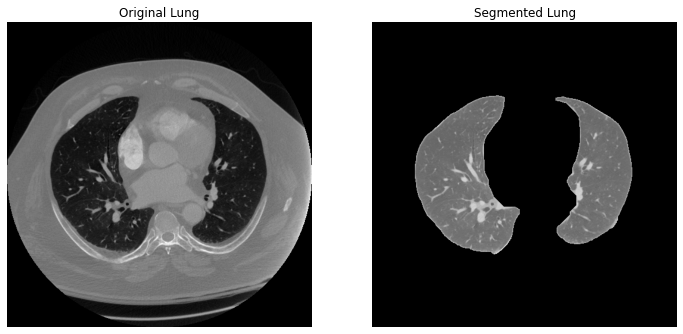

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (12, 12))

ax1.imshow(test_patient_images[100], cmap='gray')
ax1.set_title("Original Lung")
ax1.axis('off')

ax2.imshow(test_segmented, cmap='gray')
ax2.set_title("Segmented Lung")
ax2.axis('off')

plt.show()

# 1.2 Calculating Lung Volumes from CT Scans

In [17]:
def generate_markers_set(images):
    return np.array([generate_markers(img)[0] for img in images])

def calculate_lungvolume(patient_scans, patient_images):
    lung_volume = 0
    patient_masks = generate_markers_set(patient_images)
    
    for idx,patient_scan in enumerate(patient_scans):
        pixel_spacing = patient_scan.PixelSpacing
        slice_thickness = patient_scan.SliceThickness
        lung_volume += np.count_nonzero(patient_masks[idx]) * pixel_spacing[0] * pixel_spacing[0] * slice_thickness
       
    # Returns volume in cm3
    return lung_volume*0.001

In [18]:
lung_vol = calculate_lungvolume(test_patient_scans, test_patient_images)
print("The lung volume of the first patient is:", lung_vol, "cm^3")

The lung volume of the first patient is: 5930.213781142547 cm^3


# 1.3 Checking the tabular data

In [19]:
train_df = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/train.csv")
test_df = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/test.csv")
subm_df = pd.read_csv("../input/rsna-str-pulmonary-embolism-detection/sample_submission.csv")

train_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID,pe_present_on_image,negative_exam_for_pe,qa_motion,qa_contrast,flow_artifact,rv_lv_ratio_gte_1,rv_lv_ratio_lt_1,leftsided_pe,chronic_pe,true_filling_defect_not_pe,rightsided_pe,acute_and_chronic_pe,central_pe,indeterminate
0,6897fa9de148,2bfbb7fd2e8b,c0f3cb036d06,0,0,0,0,0,0,1,1,0,0,1,0,0,0
1,6897fa9de148,2bfbb7fd2e8b,f57ffd3883b6,0,0,0,0,0,0,1,1,0,0,1,0,0,0
2,6897fa9de148,2bfbb7fd2e8b,41220fda34a3,0,0,0,0,0,0,1,1,0,0,1,0,0,0
3,6897fa9de148,2bfbb7fd2e8b,13b685b4b14f,0,0,0,0,0,0,1,1,0,0,1,0,0,0
4,6897fa9de148,2bfbb7fd2e8b,be0b7524ffb4,0,0,0,0,0,0,1,1,0,0,1,0,0,0


In [20]:
test_df.head()

,StudyInstanceUID,SeriesInstanceUID,SOPInstanceUID
0,df06fad17bc3,857e3d760445,c3163725fcf6
1,df06fad17bc3,857e3d760445,d54a8daaf836
2,df06fad17bc3,857e3d760445,bdc531b699cd
3,df06fad17bc3,857e3d760445,9e6a68e27df0
4,df06fad17bc3,857e3d760445,25e3307ba7da


In [21]:
subm_df.head()

,id,label
0,df06fad17bc3_negative_exam_for_pe,0.5
1,c8039e7f9e63_negative_exam_for_pe,0.5
2,761f6f1a9f5b_negative_exam_for_pe,0.5
3,c8db5b1f6b56_negative_exam_for_pe,0.5
4,462e805da1f1_negative_exam_for_pe,0.5


# More to come!

# Conclusion:

In this kernel, we discussed about:

- What is Watershed Transformation?
- Loading Scans
- Creating Internal, External and Watershed Markers
- Getting the segmented lung images
- Using the segmented lung images for calculating volume.
- Inspecting tabular data.